# Analysis of the inferred image embeddings

In this notebook we assess the inferred image embeddings for the previosuly determined impactful gene perturbation settings. To this end, we will use the image embeddings computed during the training of the convolutional neural network.

---

## 0. Environmental setup

First, we read in the required software packages and libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy as hc
from scipy.spatial.distance import pdist, euclidean, cosine
from tqdm import tqdm
from scipy.spatial.distance import squareform
import sys
from sklearn.metrics import (
    mutual_info_score,
    adjusted_mutual_info_score,
    adjusted_rand_score,
    rand_score,
    v_measure_score,
    normalized_mutual_info_score,
)
import matplotlib as mpl
from collections import Counter
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer
from IPython.display import Image
from statannot import add_stat_annotation
import ot
import os

sys.path.append("../../..")
from src.utils.notebooks.ppi.embedding import *
from src.utils.notebooks.images.embedding import *
from src.utils.notebooks.translation.analysis import *
from src.utils.basic.io import get_genesets_from_gmt_file

mpl.rcParams["figure.dpi"] = 300

seed = 1234

2024-11-07 13:12:37.732025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def assess_cluster_topk(reg_nn_dict, struct_nn_dict, cluster_df):
    struct_topks = []
    reg_topks = []
    samples = []
    for sample in reg_nn_dict.keys():
        reg_nns = reg_nn_dict[sample]
        struct_nns = struct_nn_dict[sample]
        cluster = np.array(cluster_df.loc[sample])[0]
        n_cluster_samples = len(cluster_df.loc[cluster_df.cluster == cluster])
        if n_cluster_samples < 2:
            continue
        samples.append(sample)
        sample_struct_topks = [0]
        sample_reg_topks = [0]
        for i in range(1, len(reg_nns)):
            reg_nn_cluster = np.array(cluster_df.loc[reg_nns[i]])[0]
            struct_nn_cluster = np.array(cluster_df.loc[struct_nns[i]])[0]
            sample_struct_topks.append(
                sample_struct_topks[-1] + int(struct_nn_cluster == cluster)
            )
            sample_reg_topks.append(
                sample_reg_topks[-1] + int(reg_nn_cluster == cluster)
            )
        struct_topks.append(np.array(sample_struct_topks[1:]) / (n_cluster_samples - 1))
        reg_topks.append(np.array(sample_reg_topks[1:]) / (n_cluster_samples - 1))
    return samples, np.array(struct_topks), np.array(reg_topks)

In [3]:
def get_neighbor_dict(data, metric="euclidean"):
    samples = np.array(data.index)
    nn = NearestNeighbors(n_neighbors=len(data), metric=metric)
    sample_neighbor_dict = {}
    nn.fit(np.array(data))
    for sample in samples:
        if metric == "precomputed":
            query = np.zeros((1, len(data)))
            query[0, np.where(samples == sample)[0]] = 1
            pred_idx = nn.kneighbors(query, return_distance=False)[0]
        pred_idx = nn.kneighbors(
            np.array(data.loc[sample]).reshape(1, -1), return_distance=False
        )[0]
        sample_neighbor_dict[sample] = samples[pred_idx]
    return sample_neighbor_dict

In [4]:
def get_emd_for_embs(embs, label_col, metric="euclidean"):
    targets = np.unique(embs.loc[:, label_col])
    n_targets = len(targets)
    wd_mtx = np.infty * np.ones((n_targets, n_targets))
    for i in tqdm(range(n_targets), desc="Compute EMD"):
        source = targets[i]
        xs = np.array(embs.loc[embs.loc[:, label_col] == source]._get_numeric_data())
        ns = len(xs)
        ps = np.ones((ns,)) / ns
        for j in range(i, n_targets):
            target = targets[j]
            if source == target:
                wd_st = 0
            else:
                xt = np.array(
                    embs.loc[embs.loc[:, label_col] == target]._get_numeric_data()
                )
                nt = len(xt)
                pt = np.ones((nt,)) / nt
                m = ot.dist(xs, xt, metric=metric)
                m = m / m.max()
                wd_st = ot.emd2(ps, pt, m, numItermax=1e9)
            wd_mtx[i, j] = wd_st
            wd_mtx[j, i] = wd_st
    wd_df = pd.DataFrame(wd_mtx, columns=list(targets), index=list(targets))
    return wd_df

---

## 1. Read in data

Second, we read in the data that describes the latent embeddings of the individual images part of the respective held-out sets in the CV setting.

In [9]:
1/118
#fold 0: 0.0085
#fold 1: 0.0185
#fold 2: 0.1659
#fold 3: 0.124397
#fold 4: 0.1095
#all + compound (leave images out): 0.18959821147020584

0.00847457627118644

In [16]:
root_dir = "/data/xinyi/image2reg/data_new/experiments/jump/images/embedding/specificity_target_combined/"
img_dir=os.path.join(root_dir,'figures_excludeCompound')
os.makedirs(img_dir,exist_ok=True)

all_latents = []

latents=pd.read_hdf(os.path.join(root_dir,'all_excludeCompound/20241105_191946/test_latents.h5'))
latents["fold"] = "all"


# all_latents = [latents_0,latents_1,latents_2,latents_3]
# for i in range(4):
#     latents = pd.read_hdf(root_dir + "fold_{}/".format(i) + "test_latents.h5")
#     latents["fold"] = "fold_{}".format(i)
#     all_latents.append(latents)
# latents = pd.concat(all_latents)
print("Read in latent embeddings of shape: {}".format(np.array(latents).shape))

Read in latent embeddings of shape: (50590, 1026)


We will decode the numeric class labels to identify which regulator each embedding corresponds to.

In [19]:
spec_results = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/screen/nuclei_region/specificity_screen_results_cv.csv",
    index_col=0,
)
spec_results = spec_results.loc[spec_results["selected"]]
spec_orf_targets = set(spec_results.index)
target_list = ['ALOX5', 'ATF4', 'AXL', 'BAX', 'BCL2L11', 'BMP4', 'BRAF', 'BUB1', 'CASP8', 'CCNB1', 'CCNB2', 'CCND2', 'CCNE1', 'CCNF', 'CD40', 'CDC42', 'CDC6', 'CDCA3', 'CDK14', 'CEBPA', 'CENPE', 'CKS2', 'CREB1', 'CYBA', 'DHRS2', 'E2F1', 'FEN1', 'FKBP4', 'FN1', 'FOS', 'FOXO1', 'GLI1', 'GLI2', 'GTSE1', 'HK2', 'HRAS', 'HSPA1B', 'IGF2', 'INHBA', 'IRAK4', 'IRF7', 'JUN', 'KIF15', 'KIF23', 'KIF2C', 'KIF4A', 'KLK6', 'KPNA2', 'KRT8', 'LOXL4', 'LRP1', 'MAPK7', 'MCM3', 'MCM4', 'MCM5', 'MCM7', 'MDK', 'MMP2', 'MSH2', 'MYBL2', 'MYC', 'MYH9', 'NC', 'NCF2', 'NCOR2', 'NEK2', 'NOTCH3', 'PAK2', 'PIK3R2', 'PLCB2', 'PLCG1', 'PLK1', 'PRKCA', 'RELB', 'RHOA', 'RPS6KB1', 'RRM2', 'SKP2', 'SMO', 'SREBF1', 'TGFB1', 'TGM2', 'TIMP1', 'TINAGL1', 'TNC', 'TONSL', 'TP73', 'TPM1', 'TRAF2', 'TRIB3', 'TSC2', 'TTK', 'TUBB6', 'UBE2C', 'UBE2S', 'WEE1', 'WWTR1', 'YWHAQ']
label_dict={}
for i in range(len(target_list)):
    label_dict[target_list[i]]=i

label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
latents.loc[:, "labels"] = latents.loc[:, "labels"].map(label_dict)

oe_targets = set(list(latents.loc[:, "labels"]))

In [20]:
latents.loc[:, "labels"]

source_13_20221009_Run2_CP-CC9-R2-03_N22_2_ALOX5_CP-CC9-R2-03_N22_T0001F003L01A01Z01C01_illumcor_32.tif     ALOX5
source_13_20221017_Run3_CP-CC9-R3-03_N22_5_ALOX5_CP-CC9-R3-03_N22_T0001F006L01A01Z01C01_illumcor_102.tif    ALOX5
source_13_20221017_Run3_CP-CC9-R3-03_N22_5_ALOX5_CP-CC9-R3-03_N22_T0001F006L01A01Z01C01_illumcor_237.tif    ALOX5
source_13_20221009_Run2_CP-CC9-R2-03_N22_2_ALOX5_CP-CC9-R2-03_N22_T0001F003L01A01Z01C01_illumcor_174.tif    ALOX5
source_13_20221009_Run2_CP-CC9-R2-03_N22_2_ALOX5_CP-CC9-R2-03_N22_T0001F003L01A01Z01C01_illumcor_232.tif    ALOX5
                                                                                                            ...  
source_13_20221017_Run3_CP-CC9-R3-05_P17_5_YWHAQ_CP-CC9-R3-05_P17_T0001F006L01A01Z01C01_illumcor_118.tif    YWHAQ
source_13_20221017_Run3_CP-CC9-R3-05_P17_3_YWHAQ_CP-CC9-R3-05_P17_T0001F004L01A01Z01C01_illumcor_32.tif     YWHAQ
source_13_20221017_Run3_CP-CC9-R3-05_P17_3_YWHAQ_CP-CC9-R3-05_P17_T0001F004L01A01Z01C01_

In [21]:
oe_targets

{'ALOX5',
 'ATF4',
 'AXL',
 'BAX',
 'BCL2L11',
 'BMP4',
 'BRAF',
 'BUB1',
 'CASP8',
 'CCNB1',
 'CCNB2',
 'CCND2',
 'CCNE1',
 'CCNF',
 'CD40',
 'CDC42',
 'CDC6',
 'CDCA3',
 'CDK14',
 'CEBPA',
 'CENPE',
 'CKS2',
 'CREB1',
 'CYBA',
 'DHRS2',
 'E2F1',
 'FEN1',
 'FKBP4',
 'FN1',
 'FOS',
 'FOXO1',
 'GLI1',
 'GLI2',
 'GTSE1',
 'HK2',
 'HRAS',
 'HSPA1B',
 'IGF2',
 'INHBA',
 'IRAK4',
 'IRF7',
 'JUN',
 'KIF15',
 'KIF23',
 'KIF2C',
 'KIF4A',
 'KLK6',
 'KPNA2',
 'KRT8',
 'LOXL4',
 'LRP1',
 'MAPK7',
 'MCM3',
 'MCM4',
 'MCM5',
 'MCM7',
 'MDK',
 'MMP2',
 'MSH2',
 'MYBL2',
 'MYC',
 'MYH9',
 'NC',
 'NCF2',
 'NCOR2',
 'NEK2',
 'NOTCH3',
 'PAK2',
 'PIK3R2',
 'PLCB2',
 'PLCG1',
 'PLK1',
 'PRKCA',
 'RELB',
 'RHOA',
 'RPS6KB1',
 'RRM2',
 'SKP2',
 'SMO',
 'SREBF1',
 'TGFB1',
 'TGM2',
 'TIMP1',
 'TINAGL1',
 'TNC',
 'TONSL',
 'TP73',
 'TPM1',
 'TRAF2',
 'TRIB3',
 'TSC2',
 'TTK',
 'TUBB6',
 'UBE2C',
 'UBE2S',
 'WEE1',
 'WWTR1',
 'YWHAQ'}

---

## 2. Visualization of the embeddings

Next, we will visualize the individual image embeddings. To this end, we will use UMAP to compute a 2D representation of the individual embeddings.

### 2.1. Overview of the joint image embeddings

As a first step we show that as expected the image embeddings differ between folds which is expected by design.

---

### 2.2. Visualization of individual perturbation settings.

We now once more will plot the image embeddings of a given gene perturbation against a background established from all other gene perturbation and the control condition.

To this end, we will randomly select the image embeddigns computed for the first fold of the 4-fold Group K-Fold setup.

In [82]:
img_dir_emb=os.path.join(img_dir,'test_gene_embs')
os.makedirs(img_dir_emb,exist_ok=True)
embs_0 = plot_struct_embs_cv(latents, random_state=1234, folds=["all"],filepath=img_dir_emb)

/home/xinyiz/image2reg/notebooks/jump/ko_embedding/../../../src/utils/notebooks/images/embedding.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latents.loc[types == t] = StandardScaler().fit_transform(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [01:22<00:00,  1.19it/s]


In [81]:
plot_struct_embs_cv

<function src.utils.notebooks.images.embedding.plot_struct_embs_cv(latents, random_state=1234, folds=['fold_0', 'fold_1', 'fold_2', 'fold_3'], type_col='fold', label_col='labels', normalize_all=False, filepath=None)>

In [23]:
md_ko = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump/images/preprocessing/full_pipeline/20241018_015541/padded_nuclei_metadata_fileExists.csv.gz",
    index_col=0,
)
md_compound = pd.read_csv(
    "/data/xinyi/image2reg/data_new/experiments/jump_compound/images/preprocessing/full_pipeline/20241025_161036/padded_nuclei_metadata_fileExists.csv.gz",
    index_col=0,
)
# md=pd.concat([md_ko,md_compound[md_compound.gene_symbol=='DMSO']])


In [24]:
md_compound.index = np.array(md_compound.image_file)
md_ko.index = np.array(md_ko.image_file)
# md.index = np.array(md.image_file)

In [26]:
tmp = embs_0.merge(md_ko.loc[:, ['source','batch',"gene_symbol"]], right_index=True, left_index=True)


In [22]:
source_bin=np.copy(tmp.source)
source_bin[source_bin!='source_13']='compound'
tmp['source_bin']=source_bin

In [25]:
np.sum(source_bin=='source_13')

59436

In [26]:
np.sum(source_bin!='source_13')

381

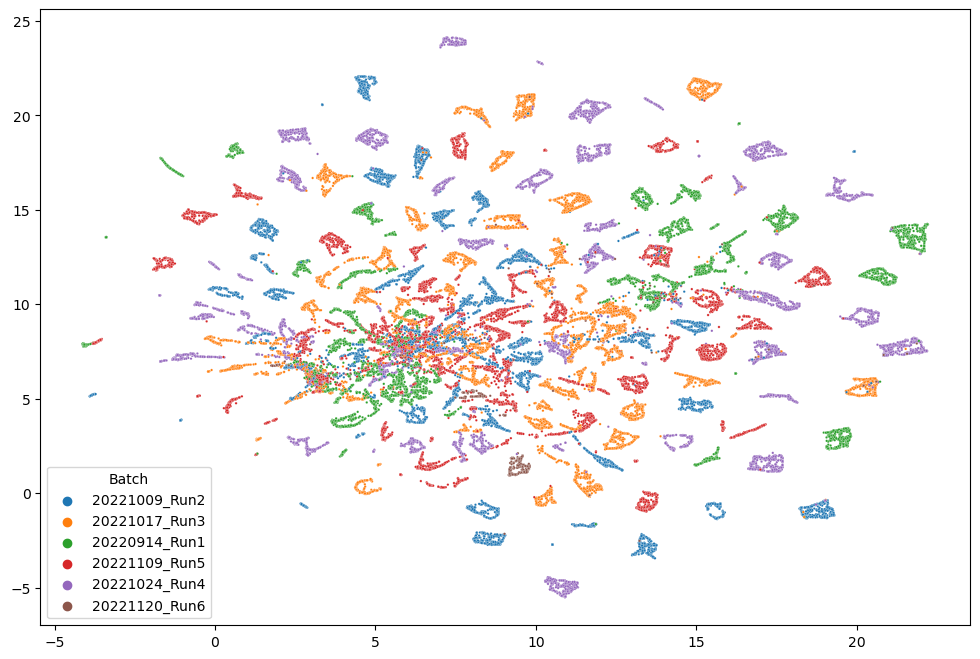

In [28]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=[12, 8])
tmp.source = np.array(tmp.source).astype(str)
ax = sns.scatterplot(data=tmp, x="umap_0", y="umap_1", hue="batch", ax=ax, s=3)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(title="Batch")
plt.show()

In [29]:
#plot train latent for batch separations
latents_train=pd.read_hdf(os.path.join(root_dir,'all_excludeCompound/20241105_191946/train_latents.h5'))
latents_train["fold"] = "all"


In [30]:
latents_train.loc[:, "labels"] = latents_train.loc[:, "labels"].map(label_dict)


In [31]:
np.sum(latents_train.labels=='NC')

12672

In [32]:
img_dir_emb_train=os.path.join(img_dir,'train_gene_embs')
os.makedirs(img_dir_emb_train,exist_ok=True)

embs_train = plot_struct_embs_cv(latents_train, random_state=1234, folds=["all"],filepath=img_dir_emb_train)


/home/xinyiz/image2reg/notebooks/jump/ko_embedding/../../../src/utils/notebooks/images/embedding.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latents.loc[types == t] = StandardScaler().fit_transform(
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [19:14<00:00, 11.78s/it]


In [36]:
latent_compound=pd.read_hdf(os.path.join(root_dir,'all_excludeCompound/20241106_103216/test_latents.h5'))

In [37]:
with open(os.path.join(img_dir_emb_train,'umap_reducer'), 'rb') as handle:
    train_reducer=pickle.load(handle)

In [38]:
latent_compound.head()

,zs_0,zs_1,zs_2,zs_3,zs_4,zs_5,zs_6,zs_7,zs_8,zs_9,...,zs_1015,zs_1016,zs_1017,zs_1018,zs_1019,zs_1020,zs_1021,zs_1022,zs_1023,labels
source_7_20210719_Run1_CP1-SC1-01_B01_1_AURKA_CP1-SC1-01_B01_T0001F002L01A01Z01C01_illumcor_1.tif,-0.127094,-0.040580,0.571562,-0.118992,-0.585601,0.036336,-0.323288,0.078121,0.209131,-0.343862,...,-0.298832,0.036023,-0.163369,-0.073362,-0.079896,-0.575034,0.070011,0.154647,-0.309766,0
source_7_20210719_Run1_CP1-SC1-01_B01_1_AURKA_CP1-SC1-01_B01_T0001F002L01A01Z01C01_illumcor_2.tif,-0.095068,-0.076382,0.510552,-0.144630,-0.515844,0.013572,-0.424415,0.051446,0.193241,-0.394740,...,-0.349464,-0.006104,-0.232440,-0.036410,-0.102477,-0.593123,0.144565,0.182744,-0.337343,0
source_7_20210719_Run1_CP1-SC1-01_B01_1_AURKA_CP1-SC1-01_B01_T0001F002L01A01Z01C01_illumcor_3.tif,-0.118579,-0.039102,0.539866,-0.121817,-0.499370,0.066700,-0.374014,0.014411,0.180000,-0.376920,...,-0.319169,-0.001627,-0.191327,-0.073294,-0.071762,-0.531608,0.116913,0.151863,-0.257003,0
source_7_20210719_Run1_CP1-SC1-01_B01_1_AURKA_CP1-SC1-01_B01_T0001F002L01A01Z01C01_illumcor_4.tif,-0.029688,0.043792,0.532117,0.007207,-0.456348,0.122150,-0.419252,0.059185,0.096620,-0.373684,...,-0.240721,-0.034825,-0.254209,-0.137953,0.075808,-0.387996,0.039944,0.257952,-0.390118,0
source_7_20210719_Run1_CP1-SC1-01_B01_1_AURKA_CP1-SC1-01_B01_T0001F002L01A01Z01C01_illumcor_5.tif,-0.181570,0.057588,0.554432,-0.009234,-0.502884,0.113383,-0.305784,0.135705,0.139300,-0.336631,...,-0.196526,-0.110346,-0.213605,-0.167497,-0.040168,-0.487082,0.061484,0.203443,-0.470185,0


In [39]:

emb_compound=train_reducer.transform(StandardScaler().fit_transform(latent_compound.loc[:, ~latent_compound.columns.isin(['labels', 'fold'])]))


In [40]:
embs_train

,umap_0,umap_1,label
source_13_20221109_Run5_CP-CC9-R5-03_N22_6_ALOX5_CP-CC9-R5-03_N22_T0001F007L01A01Z01C01_illumcor_287.tif,0.074861,1.482385,ALOX5
source_13_20220914_Run1_CP-CC9-R1-03_N22_2_ALOX5_CP-CC9-R1-03_N22_T0001F003L01A01Z01C01_illumcor_316.tif,9.019752,0.596845,ALOX5
source_13_20220914_Run1_CP-CC9-R1-03_N22_5_ALOX5_CP-CC9-R1-03_N22_T0001F006L01A01Z01C01_illumcor_310.tif,3.985745,-4.762389,ALOX5
source_13_20220914_Run1_CP-CC9-R1-03_N22_5_ALOX5_CP-CC9-R1-03_N22_T0001F006L01A01Z01C01_illumcor_345.tif,4.006537,-4.761260,ALOX5
source_13_20221017_Run3_CP-CC9-R3-03_N22_4_ALOX5_CP-CC9-R3-03_N22_T0001F005L01A01Z01C01_illumcor_154.tif,3.102615,-2.149558,ALOX5
...,...,...,...
source_13_20221024_Run4_CP-CC9-R4-05_P17_6_YWHAQ_CP-CC9-R4-05_P17_T0001F007L01A01Z01C01_illumcor_114.tif,-3.602623,1.232092,YWHAQ
source_13_20221009_Run2_CP-CC9-R2-05_P17_3_YWHAQ_CP-CC9-R2-05_P17_T0001F004L01A01Z01C01_illumcor_136.tif,-1.733284,-1.003170,YWHAQ
source_13_20221109_Run5_CP-CC9-R5-05_P17_7_YWHAQ_CP-CC9-R5-05_P17_T0001F008L01A01Z01C01_illumcor_190.tif,-2.483009,3.808926,YWHAQ
source_13_20221109_Run5_CP-CC9-R5-05_P17_3_YWHAQ_CP-CC9-R5-05_P17_T0001F004L01A01Z01C01_illumcor_117.tif,-1.435961,-0.868053,YWHAQ


In [41]:
md_compound

,source,batch,plate,well,site,image_file,gene_symbol,bb_width,bb_height,minor_axis_length,major_axis_length,aspect_ratio,aspect_ratio_cluster,nuclei_count_image,slide_image_name,aspect_ratio_cluster_ratio,centroid_0,centroid_1
source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2_CP1-SC1-06_J08_T0001F002L01A01Z01C01_illumcor_1.tif,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,27,32,27.263139,33.298781,0.818743,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,22.942335,1232.897328
source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2_CP1-SC1-06_J08_T0001F002L01A01Z01C01_illumcor_2.tif,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,35,19,18.711072,36.371191,0.514448,1,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,29.754753,552.490494
source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2_CP1-SC1-06_J08_T0001F002L01A01Z01C01_illumcor_3.tif,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,28,30,23.319638,33.555792,0.694951,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,29.530945,840.661238
source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2_CP1-SC1-06_J08_T0001F002L01A01Z01C01_illumcor_4.tif,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,34,27,22.989829,36.280641,0.633667,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,37.877301,881.897239
source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2_CP1-SC1-06_J08_T0001F002L01A01Z01C01_illumcor_5.tif,source_7,20210719_Run1,CP1-SC1-06,J08,1,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,APPBP2,29,34,26.717761,36.065574,0.740811,0,202,source_7_20210719_Run1_CP1-SC1-06_J08_1_APPBP2...,NaN,36.644180,994.552910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
source_5_JUMPCPE-20211014-Run36_20211014_223431_AETJUM427_O02_9_DMSO_P07_AETJUM427_O02_T0001F009L01A01Z01C01_illumcor_296.tif,source_5,JUMPCPE-20211014-Run36_20211014_223431,AETJUM427,O02,9,source_5_JUMPCPE-20211014-Run36_20211014_22343...,DMSO,33,20,19.864287,33.137993,0.599441,1,248,source_5_JUMPCPE-20211014-Run36_20211014_22343...,NaN,971.052000,94.754000
source_5_JUMPCPE-20211014-Run36_20211014_223431_AETJUM427_O02_9_DMSO_P07_AETJUM427_O02_T0001F009L01A01Z01C01_illumcor_299.tif,source_5,JUMPCPE-20211014-Run36_20211014_223431,AETJUM427,O02,9,source_5_JUMPCPE-20211014-Run36_20211014_22343...,DMSO,38,44,31.527705,45.874272,0.687263,0,248,source_5_JUMPCPE-20211014-Run36_20211014_22343...,NaN,976.302387,498.809019
source_5_JUMPCPE-20211014-Run36_20211014_223431_AETJUM427_O02_9_DMSO_P07_AETJUM427_O02_T0001F009L01A01Z01C01_illumcor_300.tif,source_5,JUMPCPE-20211014-Run36_20211014_223431,AETJUM427,O02,9,source_5_JUMPCPE-20211014-Run36_20211014_22343...,DMSO,18,33,17.211879,33.431809,0.514835,1,248,source_5_JUMPCPE-20211014-Run36_20211014_22343...,NaN,967.394678,166.880266
source_5_JUMPCPE-20211014-Run36_20211014_223431_AETJUM427_O02_9_DMSO_P07_AETJUM427_O02_T0001F009L01A01Z01C01_illumcor_301.tif,source_5,JUMPCPE-20211014-Run36_20211014_223431,AETJUM427,O02,9,source_5_JUMPCPE-20211014-Run36_20211014_22343...,DMSO,22,30,18.515447,32.022511,0.578201,1,248,source_5_JUMPCPE-20211014-Run36_20211014_22343...,NaN,976.746137,40.079470


In [42]:
image_meta_metadata=pd.read_csv("/data/xinyi/image2reg/data_new/resources/images/jump_compound/metadata/image_metadata_full.csv.gz")


/tmp/ipykernel_952095/4018045165.py:1: DtypeWarning: Columns (542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1963,1967,2002,2008,2009,2010,2011,2013,2016) have mixed types. Specify dtype option on import or set low_memory=False.
  image_meta_metadata=pd.read_csv("/data/xinyi/image2reg/data_new/resources/images/jump_compound/metadata/image_metadata_full.csv.gz")


In [43]:
image_meta_metadata

,Unnamed: 0.1,Unnamed: 0,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_Site,Count_Cells,Count_CellsIncludingEdges,Count_Cytoplasm,...,PathName_OrigER,PathName_OrigMito,PathName_OrigRNA,Unnamed: 0_x,Metadata_JCP2022,Unnamed: 0_y,Metadata_InChIKey,Metadata_InChI,Metadata_PlateType,Metadata_Symbol
0,0,0,source_8,A1166128,A17,J3,1,113.0,129.0,113.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,848036,JCP2022_033924,33641,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND,DMSO
1,1,1,source_8,A1166128,A17,J3,2,121.0,138.0,121.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,848036,JCP2022_033924,33641,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND,DMSO
2,2,2,source_8,A1166128,A17,J3,3,151.0,168.0,151.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,848036,JCP2022_033924,33641,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND,DMSO
3,3,3,source_8,A1166128,A17,J3,4,179.0,193.0,179.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,848036,JCP2022_033924,33641,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND,DMSO
4,4,4,source_8,A1166128,A17,J3,5,150.0,168.0,150.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,848036,JCP2022_033924,33641,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,COMPOUND,DMSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111616,111616,111616,source_1,UL001799,Z03,Batch5_20221030,4,70.0,77.0,70.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,80568,JCP2022_037716,37405,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,COMPOUND,AURKA
111617,111617,111617,source_1,UL001799,Z46,Batch5_20221030,1,31.0,36.0,31.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,80611,JCP2022_037716,37405,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,COMPOUND,AURKA
111618,111618,111618,source_1,UL001799,Z46,Batch5_20221030,2,31.0,41.0,31.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,80611,JCP2022_037716,37405,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,COMPOUND,AURKA
111619,111619,111619,source_1,UL001799,Z46,Batch5_20221030,3,78.0,89.0,78.0,...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,s3://cellpainting-gallery/cpg0016-jump/source_...,80611,JCP2022_037716,37405,IVUGFMLRJOCGAS-UHFFFAOYSA-N,InChI=1S/C28H21N7OS/c1-17-15-24(37-16-17)25-20...,COMPOUND,AURKA


In [44]:
tmp_compound=pd.DataFrame(emb_compound, columns=['umap_0','umap_1'])

In [45]:
tmp_compound.index=latent_compound.index
tmp_compound['label']=latent_compound.labels

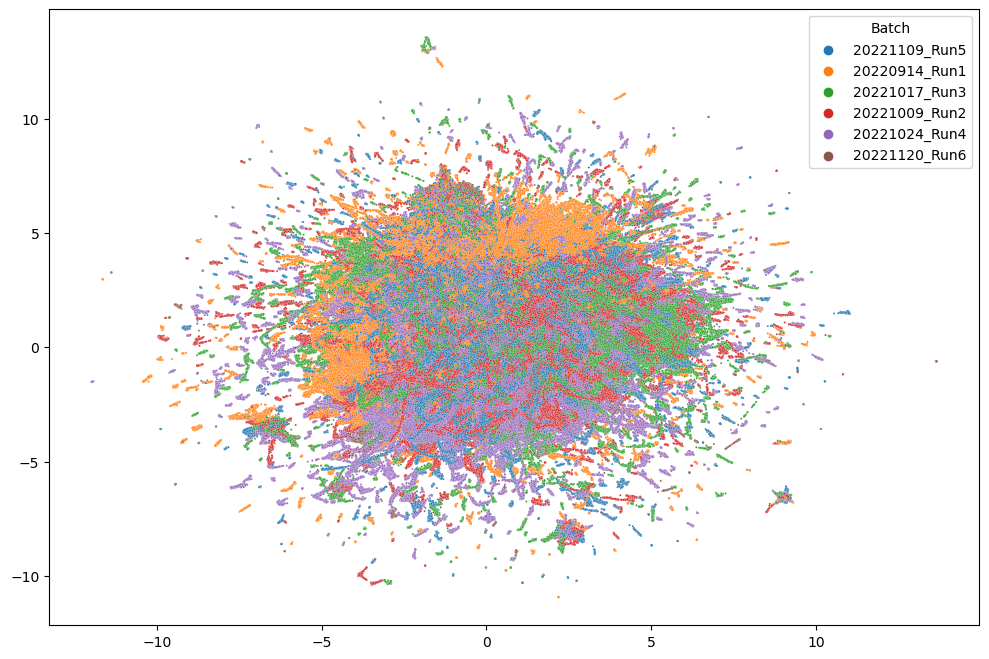

In [46]:
tmp_train = embs_train.merge(md_ko.loc[:, ['source','batch',"gene_symbol"]], right_index=True, left_index=True)
plt.style.use("default")
fig, ax = plt.subplots(figsize=[12, 8])
tmp_train.source = np.array(tmp_train.source).astype(str)
ax = sns.scatterplot(data=tmp_train, x="umap_0", y="umap_1", hue="batch", ax=ax, s=2)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(title="Batch")
plt.show()

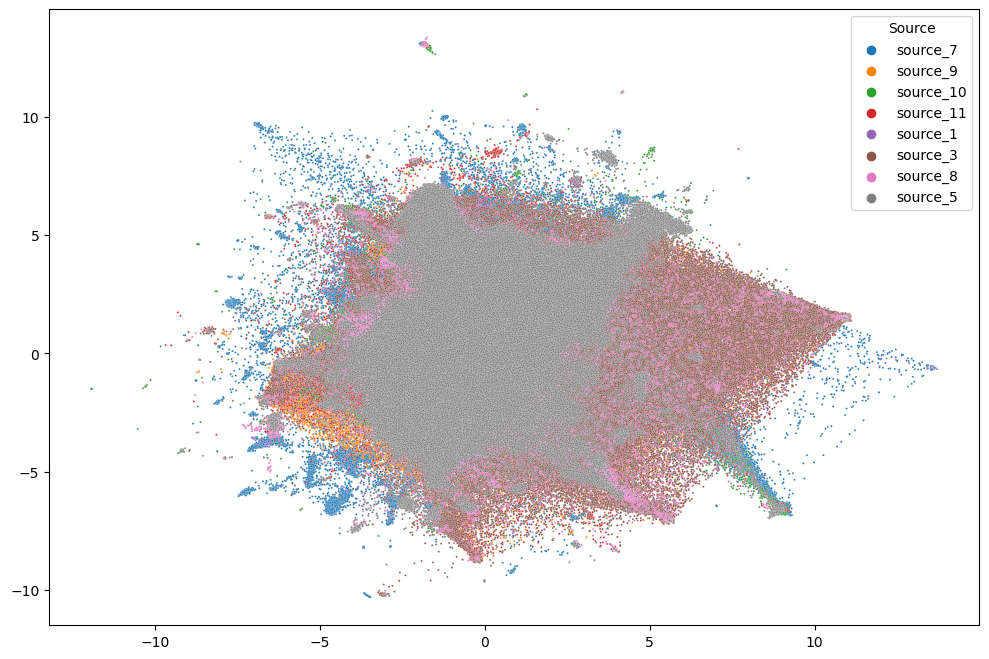

In [47]:
tmp_compound = tmp_compound.merge(md_compound.loc[:, ['source',"gene_symbol"]], right_index=True, left_index=True)
plt.style.use("default")
fig, ax = plt.subplots(figsize=[12, 8])
tmp_compound.source = np.array(tmp_compound.source).astype(str)
ax = sns.scatterplot(data=tmp_compound, x="umap_0", y="umap_1", hue="source", ax=ax, s=2)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(title="Source")
plt.show()

In [57]:
tmp_compound=pd.DataFrame(emb_compound, columns=['umap_0','umap_1'])
tmp_compound.index=latent_compound.index
tmp_compound['label']=latent_compound.labels

target_list_compound=np.array(['AURKA', 'AURKB', 'BIRC5', 'CCNA2', 'CDK1', 'CDK2', 'CDK6',
       'EEF1A2', 'FGF1', 'FGFR3', 'GSK3B', 'MAP3K2', 'MAP3K5', 'MAP3K9',
       'MAPK8', 'NC', 'PARP2', 'PCNA', 'PRKACA', 'RARA', 'THRA'])
label_dict_compound={}
for i in range(len(target_list_compound)):
    label_dict_compound[target_list_compound[i]]=i

label_dict_compound = dict(zip(list(label_dict_compound.values()), list(label_dict_compound.keys())))
tmp_compound.loc[:, "label"] = tmp_compound.loc[:, "label"].map(label_dict_compound)
tmp_compound = tmp_compound.merge(md_compound.loc[:, ['source',"gene_symbol"]], right_index=True, left_index=True)
tmp_compound.shape

(12776299, 5)

In [59]:
img_dir_emb_comb=os.path.join(img_dir,'train_test_gene_embs')
os.makedirs(img_dir_emb_comb,exist_ok=True)
for g in np.unique(tmp_compound.label):
    print(g)
    tmp_plot = pd.concat([tmp_compound[tmp_compound.label==g],tmp_train[tmp_train.label==g]])
    plt.style.use("default")
    fig, ax = plt.subplots(figsize=[12, 8])
    ax = sns.scatterplot(data=tmp_plot, x="umap_0", y="umap_1", hue="source", ax=ax, s=2)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(title="Source")
    ax.set_title(g)
    plt.savefig(os.path.join(img_dir_emb_comb,g+'.jpg'))
    plt.close()

AURKA
AURKB
BIRC5
CCNA2
CDK1
CDK2
CDK6
EEF1A2
FGF1
FGFR3
GSK3B
MAP3K2
MAP3K5
MAP3K9
MAPK8
NC
PARP2
PCNA
PRKACA
RARA
THRA


In [ ]:
img_dir_emb_comb=os.path.join(img_dir,'train_test_gene_embs_bg')
os.makedirs(img_dir_emb_comb,exist_ok=True)
for g in np.unique(tmp_compound.label):
    print(g)
    tmp_plot = pd.concat([tmp_compound[tmp_compound.label==g],tmp_train[tmp_train.label==g]])
    plt.style.use("default")
    fig, ax = plt.subplots(figsize=[12, 8])
    tmp_bg = pd.concat([tmp_compound[tmp_compound.label!=g],tmp_train[tmp_train.label!=g]])
    ax.scatter(tmp_bg["umap_0"],tmp_bg["umap_1"], c="tab:gray",alpha=0.03,s=4)
    ax.scatter(tmp_plot["umap_0"],tmp_plot["umap_1"], c="red",alpha=0.7,s=4)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # ax.legend(title="Source")
    ax.set_title(g)
    plt.savefig(os.path.join(img_dir_emb_comb,g+'.jpg'))
    plt.close()

AURKA
AURKB
BIRC5
CCNA2
CDK1
CDK2
CDK6
EEF1A2
FGF1
FGFR3
GSK3B
MAP3K2
MAP3K5
MAP3K9
MAPK8
NC
PARP2
PCNA
PRKACA
RARA
THRA


In [62]:
testconf=pd.read_csv(os.path.join(root_dir,'all_excludeCompound/20241106_103216/test_cmatrix.csv'),index_col=0)

In [64]:
testconf=testconf.iloc[:len(target_list_compound)]

In [66]:
testconf.index=target_list_compound

In [67]:
testconf

,ALOX5,ATF4,AXL,BAX,BCL2L11,BMP4,BRAF,BUB1,CASP8,CCNB1,...,TRAF2,TRIB3,TSC2,TTK,TUBB6,UBE2C,UBE2S,WEE1,WWTR1,YWHAQ
AURKA,0.000492,0.000002,0.000000,0.556776,0.000088,0.000013,0.000004,0.000023,0.005213,0.000031,...,0.000483,0.000010,0.000032,0.013504,0.000024,0.000897,0.012212,0.000173,0.005629,0.000191
AURKB,0.038791,0.000650,0.000000,0.041500,0.103370,0.000000,0.000108,0.000758,0.000867,0.001409,...,0.000433,0.005418,0.000000,0.009969,0.028389,0.002817,0.000758,0.000542,0.000325,0.000000
BIRC5,0.042956,0.000126,0.000084,0.003794,0.005902,0.000885,0.000169,0.000000,0.002614,0.000000,...,0.000084,0.004848,0.006787,0.000169,0.000464,0.012225,0.000885,0.000169,0.002951,0.018422
CCNA2,0.025765,0.000000,0.000000,0.204831,0.003140,0.000564,0.000000,0.000081,0.005797,0.000000,...,0.070531,0.000000,0.001771,0.000000,0.000242,0.001208,0.012158,0.001369,0.000242,0.007890
CDK1,0.054057,0.000325,0.000000,0.027216,0.011757,0.000525,0.000150,0.000000,0.002552,0.000025,...,0.000600,0.000225,0.002827,0.001076,0.002527,0.006104,0.000901,0.001576,0.001051,0.004503
CDK2,0.027834,0.000323,0.000000,0.155609,0.007241,0.000830,0.000000,0.000000,0.004612,0.000023,...,0.026704,0.000023,0.000623,0.002813,0.000461,0.009708,0.007471,0.002883,0.007149,0.006618
CDK6,0.052643,0.000173,0.000035,0.003764,0.005568,0.001457,0.000260,0.000000,0.001093,0.000069,...,0.000087,0.000833,0.010650,0.000017,0.002272,0.006140,0.000572,0.000017,0.002411,0.008100
EEF1A2,0.042033,0.000000,0.000000,0.002612,0.005699,0.000237,0.000237,0.000000,0.002612,0.000000,...,0.000000,0.000000,0.001544,0.000000,0.000237,0.003562,0.000712,0.000000,0.001662,0.000950
FGF1,0.029763,0.000131,0.000000,0.107289,0.005030,0.000865,0.000052,0.000026,0.010166,0.000079,...,0.011711,0.000183,0.000812,0.000079,0.000157,0.015275,0.005371,0.002699,0.004664,0.010716
FGFR3,0.020537,0.000471,0.000000,0.335600,0.004175,0.001414,0.000000,0.000000,0.012390,0.000000,...,0.036765,0.000135,0.001279,0.000000,0.000539,0.015689,0.005185,0.000202,0.005320,0.015083


In [ ]:
testconf_sub=testconf.loc[:,np.array(target_list_compound)] 
#exclude what's not in training
#store individual accuracy

In [ ]:
np.mean(np.diag(testconf_sub))

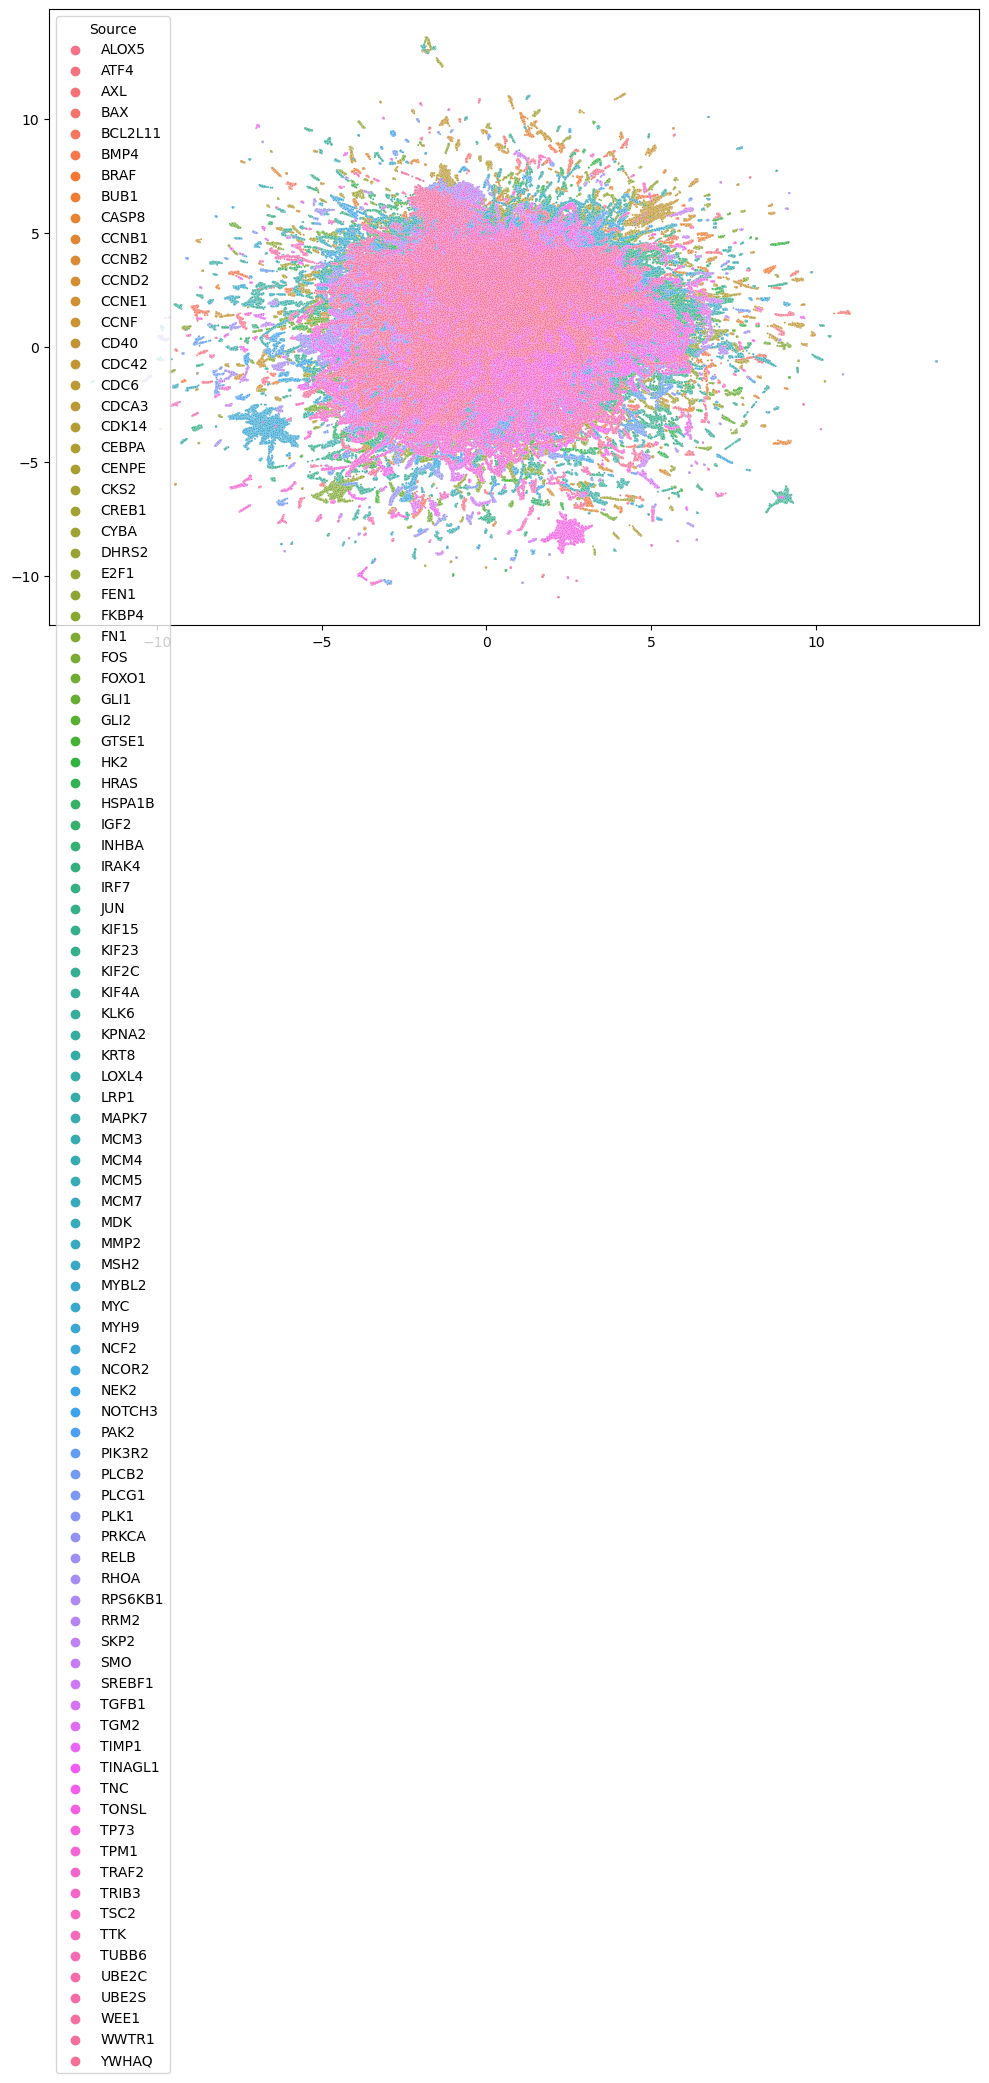

In [69]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=[12, 8])
# tmp_train.source = np.array(tmp_train.source).astype(str)
ax = sns.scatterplot(data=tmp_train[tmp_train.label!='NC'], x="umap_0", y="umap_1", hue="gene_symbol", ax=ax, s=2)
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend(title="Source",loc='upper left')
plt.show()

In [70]:
#save train embedding
save_train = latents_train.merge(md_ko.loc[:, ['source','batch','plate','well','site',"gene_symbol"]], right_index=True, left_index=True)


In [71]:
save_train['site_level']=[a +'_'+ b+'_'+c+'_'+str(d) for a, b,c,d in zip(save_train.batch, save_train.plate,save_train.well,save_train.site)]
save_train['well_level']=[a +'_'+ b+'_'+c for a, b,c in zip(save_train.batch, save_train.plate,save_train.well)]

In [72]:
aggregation_functions = {col: 'mean' for col in save_train.select_dtypes(include='number').columns}
aggregation_functions.update({col: 'first' for col in save_train.select_dtypes(include='object').columns})

save_train_mean_site=save_train.groupby('site_level').agg(aggregation_functions)
save_train_mean_site.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/train_latents_site_mean.csv'))

In [73]:
save_train_mean_well=save_train.groupby('well_level').agg(aggregation_functions)
save_train_mean_well.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/train_latents_well_mean.csv'))

In [75]:
save_test = latents.merge(md_ko.loc[:, ['source','batch','plate','well','site',"gene_symbol"]], right_index=True, left_index=True)
save_test['site_level']=[a +'_'+ b+'_'+c+'_'+str(d) for a, b,c,d in zip(save_test.batch, save_test.plate,save_test.well,save_test.site)]
save_test['well_level']=[a +'_'+ b+'_'+c for a, b,c in zip(save_test.batch, save_test.plate,save_test.well)]
aggregation_functions = {col: 'mean' for col in save_test.select_dtypes(include='number').columns}
aggregation_functions.update({col: 'first' for col in save_test.select_dtypes(include='object').columns})

save_test_mean_site=save_test.groupby('site_level').agg(aggregation_functions)
save_test_mean_site.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/test_latents_site_mean.csv'))
save_test_mean_well=save_test.groupby('well_level').agg(aggregation_functions)
save_test_mean_well.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/test_latents_well_mean.csv'))

In [77]:
save_compound_overlap = latent_compound.merge(md_compound.loc[:, ['source','batch','plate','well','site',"gene_symbol"]], right_index=True, left_index=True)
save_compound_overlap['site_level']=[a +'_'+ b+'_'+c+'_'+str(d) for a, b,c,d in zip(save_compound_overlap.batch, save_compound_overlap.plate,save_compound_overlap.well,save_compound_overlap.site)]
save_compound_overlap['well_level']=[a +'_'+ b+'_'+c for a, b,c in zip(save_compound_overlap.batch, save_compound_overlap.plate,save_compound_overlap.well)]
save_compound_overlap=save_compound_overlap[save_compound_overlap.gene_symbol!='DMSO']
print('subset')
aggregation_functions = {col: 'mean' for col in save_compound_overlap.select_dtypes(include='number').columns}
aggregation_functions.update({col: 'first' for col in save_compound_overlap.select_dtypes(include='object').columns})

save_compound_overlap_mean_site=save_compound_overlap.groupby('site_level').agg(aggregation_functions)
save_compound_overlap_mean_site.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/compound_overlap_latents_site_mean.csv'))
save_compound_overlap_mean_well=save_compound_overlap.groupby('well_level').agg(aggregation_functions)
save_compound_overlap_mean_well.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/compound_overlap_latents_well_mean.csv'))

subset


In [ ]:
save_compound_others

In [78]:
latent_compound_others=pd.read_hdf(os.path.join(root_dir,'all_excludeCompound/20241106_103455/test_latents.h5'))
save_compound_others = latent_compound_others.merge(md_compound.loc[:, ['source','batch','plate','well','site',"gene_symbol"]], right_index=True, left_index=True)
save_compound_others['site_level']=[a +'_'+ b+'_'+c+'_'+str(d) for a, b,c,d in zip(save_compound_others.batch, save_compound_others.plate,save_compound_others.well,save_compound_others.site)]
save_compound_others['well_level']=[a +'_'+ b+'_'+c for a, b,c in zip(save_compound_others.batch, save_compound_others.plate,save_compound_others.well)]
save_compound_others=save_compound_others[save_compound_others.gene_symbol!='DMSO']
aggregation_functions = {col: 'mean' for col in save_compound_others.select_dtypes(include='number').columns}
aggregation_functions.update({col: 'first' for col in save_compound_others.select_dtypes(include='object').columns})

save_compound_others_mean_site=save_compound_others.groupby('site_level').agg(aggregation_functions)
save_compound_others_mean_site.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/compound_others_latents_site_mean.csv'))
save_compound_others_mean_well=save_compound_others.groupby('well_level').agg(aggregation_functions)
save_compound_others_mean_well.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/compound_others_latents_well_mean.csv'))

In [79]:
save_compound_others_mean_site=save_compound_others.groupby('batch').agg(aggregation_functions)
save_compound_others_mean_site.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/compound_others_latents_batch_mean.csv'))


In [80]:
save_compound_overlap_mean_site=save_compound_overlap.groupby('batch').agg(aggregation_functions)
save_compound_overlap_mean_site.to_csv(os.path.join(root_dir,'all_excludeCompound/20241105_191946/compound_overlap_latents_batch_mean.csv'))
